In [51]:
# Importing necessary libraries
from pythtb import *
import matplotlib.pyplot as plt
import ray
import pandas as pd

# Initializing the Wannier90 model by reading the data files
pgda=w90(r"PdGa_Ham2",r"wannier90")
my_model=pgda.model(min_hopping_norm=0.01) # only hoppings with norm greater than 0.01 are considered

### Task 1: Visualize the bands

In [59]:
# Choosing the path
path=[[0.5,0.0,0.0],[0.5,-0.5,0.0],[0.0,0.0, 0.0],[0.5,0.5,0.5],[0.5,0.0,0.0]]
k_label=(r'$X$', r'$M$', r'$\Gamma$', r'$R$', r'$X$')
(k_vec,k_dist,k_node)=my_model.k_path(path,101,report=False)

# Finding the energy eigenvalues at all k-points
evals=my_model.solve_all(k_vec)
energies = evals - 6.87 # Subtructing the Fermi energy

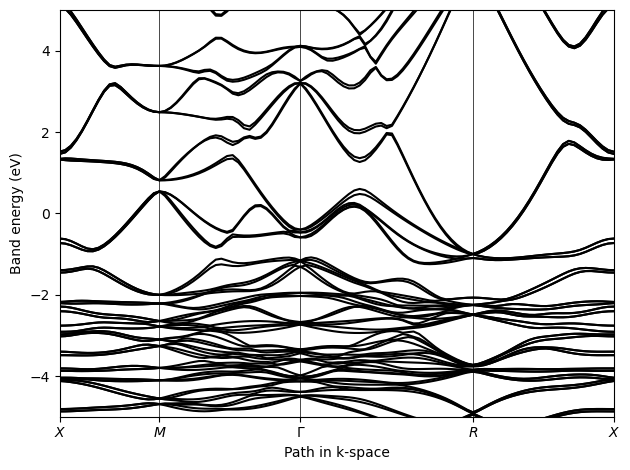

In [60]:
# Plotting the bands
fig, ax = plt.subplots()
for i in range(evals.shape[0]):
    ax.plot(k_dist,energies[i],"-k")
for n in range(len(k_node)):
    ax.axvline(x=k_node[n],linewidth=0.5, color='k')
ax.set_xlabel("Path in k-space")
ax.set_ylabel("Band energy (eV)")
ax.set_xlim(k_dist[0],k_dist[-1])
ax.set_ylim(-5, 5)
ax.set_xticks(k_node)
ax.set_xticklabels(k_label)
fig.tight_layout()

plt.show()

### Task 2:

In [12]:
# To write the band velocity operator at a k-point
def calculate_v(k_vec, dk=0.01):
    H = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]])
    Hx = my_model._gen_ham([k_vec[0]+dk, k_vec[1], k_vec[2]])
    Hy = my_model._gen_ham([k_vec[0], k_vec[1]+dk, k_vec[2]])
    Hz = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]+dk])

    vx = (Hx-H)/dk
    vy = (Hy-H)/dk
    vz = (Hz-H)/dk
    return np.array((vx, vy, vz))

In [13]:
# To get energy eigenvalues and corresponding OAMs at a k-point
def solve_and_calculate_L(k_vec, eta=0.01):
    v = calculate_v(k_vec)                  # velocity using forward finite difference
    #v = my_model.derivative_ham(k_vec)     # velocity using exact derivative formula
    
    # Getting energy eigenvalues and vectors
    (eig_values, eig_vectors) = my_model.solve_one(k_vec, eig_vectors=True)
    
    # Calculating 3 components of OAM
    Lx = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[1]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[2]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[2]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Lx[n] = np.imag(temp)
    Ly = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[2]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[0]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[2]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Ly[n] = np.imag(temp)
    Lz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[1]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[0]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Lz[n] = np.imag(temp)
    return (eig_values, np.array((Lx, Ly, Lz)))

R_Gamma_R path

In [14]:
# Choosing the path
path=[[-0.5,-0.5,-0.5],[0.0,0.0, 0.0],[0.5,0.5,0.5]]
k_label=(r'$R$', r'$\Gamma$', r'$R$')
(k_vec,k_dist,k_node)=my_model.k_path(path,501,report=False)

# Calculating OAM
evals = np.zeros((64, k_vec.shape[0]))
L = np.zeros((3, 64, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], L[:,:, i]) = solve_and_calculate_L(k_vec[i])
    if i%50 == 0:
        print(i+1, "points done.")

energies = evals-6.87
colors = L[0]+L[1]+L[2]     # L_111

1 points done.
51 points done.
101 points done.
151 points done.
201 points done.
251 points done.
301 points done.
351 points done.
401 points done.
451 points done.
501 points done.


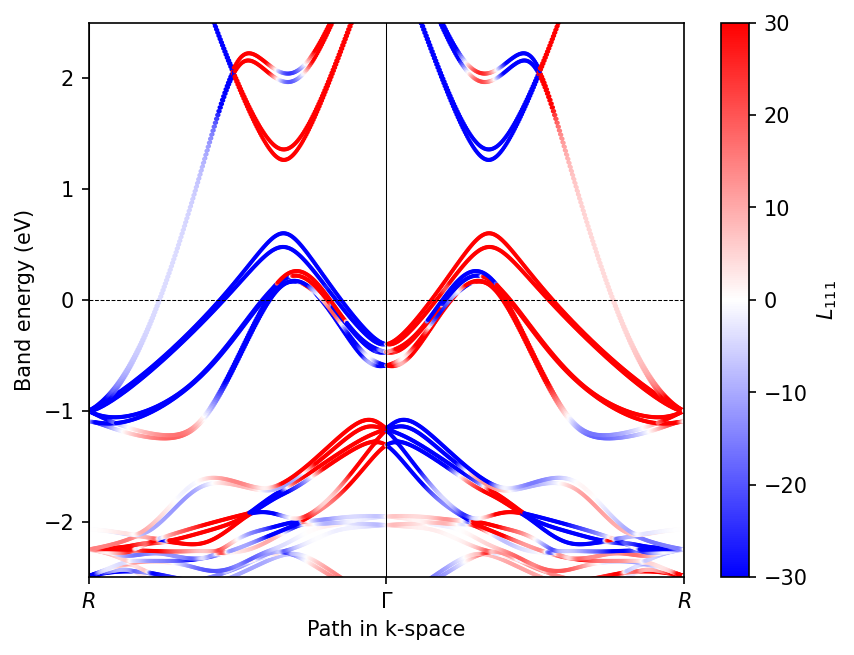

In [17]:
# Plotting
plt.figure(dpi = 150)
plt.set_cmap('bwr')
cmax = 30
for i in range(evals.shape[0]):
    plt.scatter(k_dist, energies[i], s=1, c=colors[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$L_{111}$")
for n in range(len(k_node)):
    plt.axvline(x=k_node[n],linewidth=0.5, color='k')

plt.hlines(0, np.min(k_dist), np.max(k_dist), lw = 0.5, ls = "--", color = "black")
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist[0],k_dist[-1])
plt.ylim(-2.5, 2.5)
plt.xticks(k_node, labels=k_label)
plt.show()

Z_Gamma_Z path

In [65]:
# Choosing the path
path_xtra1=[[0,0,-0.5],[0.0,0.0, 0.0],[0,0,0.5]]
k_label_xtra1=(r'$Z$', r'$\Gamma$', r'$Z$')
(k_vec_xtra1,k_dist_xtra1,k_node_xtra1)=my_model.k_path(path_xtra1,501,report=False)

# Calculating OAM
evals_xtra1 = np.zeros((64, k_vec_xtra1.shape[0]))
L_xtra1 = np.zeros((3, 64, k_vec_xtra1.shape[0]))
for i in range(k_vec_xtra1.shape[0]):
    (evals_xtra1[:, i], L_xtra1[:,:, i]) = solve_and_calculate_L(k_vec_xtra1[i])
    if i%50 == 0:
        print(i+1, "points done.")

energies_xtra1 = evals_xtra1-6.87
colors_xtra1 = L_xtra1[2]     # L_001

1 points done.
51 points done.
101 points done.
151 points done.
201 points done.
251 points done.
301 points done.
351 points done.
401 points done.
451 points done.
501 points done.


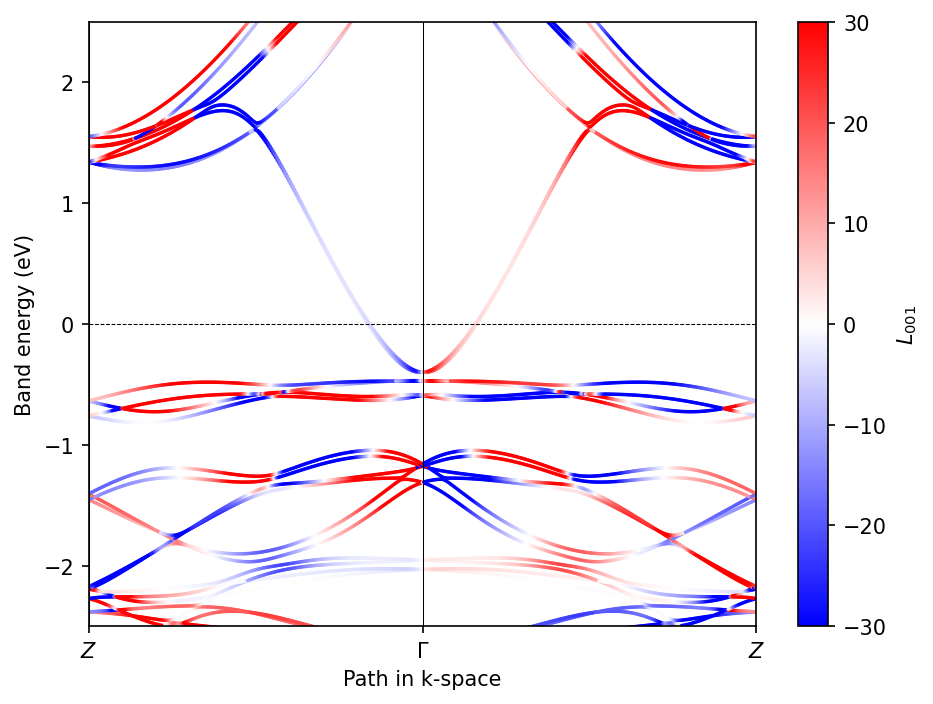

In [66]:
# Plotting
plt.figure(dpi = 150)
plt.set_cmap('bwr')
cmax = 30
for i in range(evals_xtra1.shape[0]):
    plt.scatter(k_dist_xtra1, energies_xtra1[i], marker = ".", s=2, c=colors_xtra1[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$L_{001}$")
for n in range(len(k_node_xtra1)):
    plt.axvline(x=k_node_xtra1[n],linewidth=0.5, color='k')\
    
plt.hlines(0, np.min(k_dist_xtra1), np.max(k_dist_xtra1), lw = 0.5, ls = "--", color = "black")
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist_xtra1[0],k_dist_xtra1[-1])
plt.ylim(-2.5, 2.5)
plt.xticks(k_node_xtra1, labels=k_label_xtra1)
plt.tight_layout()
plt.show()

M_Gamma_M Path

In [67]:
# Choosing the path
path_xtra2=[[-0.5,-0.5,0],[0.0,0.0, 0.0],[0.5,0.5,0]]
k_label_xtra2=(r'$M$', r'$\Gamma$', r'$M$')
(k_vec_xtra2,k_dist_xtra2,k_node_xtra2)=my_model.k_path(path_xtra2,501,report=False)

# Calculating OAM
evals_xtra2 = np.zeros((64, k_vec_xtra2.shape[0]))
L_xtra2 = np.zeros((3, 64, k_vec_xtra2.shape[0]))
for i in range(k_vec.shape[0]):
    (evals_xtra2[:, i], L_xtra2[:,:, i]) = solve_and_calculate_L(k_vec_xtra2[i])
    if i%50 == 0:
        print(i+1, "points done.")

energies_xtra2 = evals_xtra2-6.87
colors_xtra2 = L_xtra2[0] + L_xtra2[1]     # L_110

1 points done.
51 points done.
101 points done.
151 points done.
201 points done.
251 points done.
301 points done.
351 points done.
401 points done.
451 points done.
501 points done.


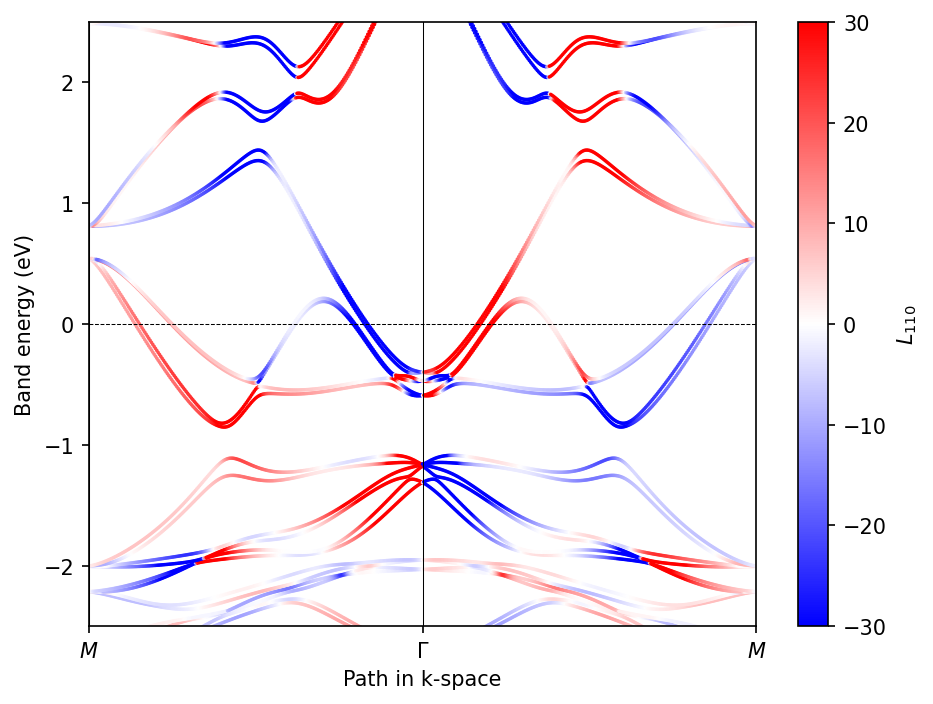

In [72]:
# Plotting
plt.figure(dpi = 150)
plt.set_cmap('bwr')
cmax = 30
for i in range(evals_xtra2.shape[0]):
    plt.scatter(k_dist_xtra2, energies_xtra2[i], marker = ".", s=2, c=colors_xtra2[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$L_{110}$")
for n in range(len(k_node_xtra2)):
    plt.axvline(x=k_node_xtra2[n],linewidth=0.5, color='k')

plt.hlines(0, np.min(k_dist_xtra2), np.max(k_dist_xtra2), lw = 0.5, ls = "--", color = "black")
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist_xtra2[0],k_dist_xtra2[-1])
plt.ylim(-2.5, 2.5)
plt.xticks(k_node_xtra2, labels=k_label_xtra2)
plt.tight_layout()
plt.show()

# Task 3


$j^z_x=\frac{1}{2} \left\{ v_x,L_z \right\}$

$\Omega^{z}_{n,xy}=-2 Im \sum_{m \neq n}\frac{ \langle n(k)|j^{z}_{x}|m(k)\rangle \langle m(k)|v_{y}|n(k)\rangle}{( E_n(k)-E_m(k))^2}$

In [66]:
# To get energy eigenvalues and corresponding OBC (Omega^z_xy) at a k-point
def solve_and_calculate_Omega_xyz(k_vec, eta=0.0001):
    v = calculate_v(k_vec)                  # velocity using forward finite difference
    #v = my_model.derivative_ham(k_vec)     # velocity using exact derivative formula
    (eig_values, eig_vectors) = my_model.solve_one(k_vec, eig_vectors=True)
    
    # Calculating L_z
    Lz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[1]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[0]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Lz[n] = np.imag(temp)
    
    # Calculating Omega^z_xy
    Omega_xyz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp -= (Lz[m]+Lz[n])*(eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))**2
        Omega_xyz[n] = np.imag(temp/2)
    return (eig_values, Omega_xyz)

In [74]:
# Choosing the path
path=[[0.0,0.0, 0.0],[0.5,0.0, 0.0],[0.5,0.5,0.0],[0.0,0.0, 0.0],[0.5,0.5,0.5],[0.5,0.0, 0.0]]
k_label=(r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$', r'$R$', r'$X$')
(k_vec,k_dist,k_node)=my_model.k_path(path,501,report=False)

# Calculating OBC
evals = np.zeros((64, k_vec.shape[0]))
Omega_xyz = np.zeros((64, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], Omega_xyz[:, i]) = solve_and_calculate_Omega_xyz(k_vec[i])
    if i%100 == 0:
        print(i+1, "points done.")

colors = Omega_xyz
energies = evals -6.87

1 points done.
101 points done.
201 points done.
301 points done.
401 points done.
501 points done.


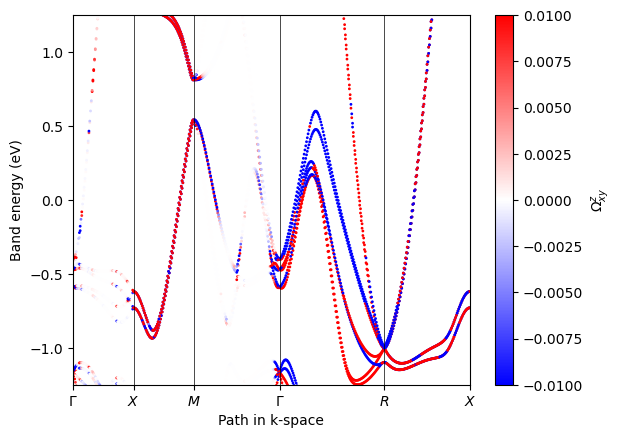

In [75]:
# Plotting
cmax = 0.01
plt.set_cmap('bwr')
for i in range(energies.shape[0]):
    plt.scatter(k_dist,energies[i], s=1, c=Omega_xyz[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$\\Omega^z_{xy}$")
for n in range(len(k_node)):
    plt.axvline(x=k_node[n],linewidth=0.5, color='k')
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist[0],k_dist[-1])
plt.ylim(-1.25, 1.25)
plt.xticks(k_node, labels=k_label)
plt.show()

# Orbital Hall Conductivity

In [77]:
# Constants
e = 1  # elementary charge (Coulombs)
hbar = 1  # reduced Planck constant (J·s)
Nk = 50  # k-mesh size in each direction
eta = 0.0001  # broadening
fermi_energy = 6.87  # from earlier

# Uniform grid in k-space
k_mesh = np.linspace(0, 1, Nk, endpoint=False)
kpoints = np.array(np.meshgrid(k_mesh, k_mesh, k_mesh)).T.reshape(-1,3)

total_ohc = 0
volume_element = (2*np.pi)**3 / len(kpoints)  # Normalized BZ volume per k-point
count = 0

for k_vec in kpoints:
    evals, Omega = solve_and_calculate_Omega_xyz(k_vec, eta=eta)
    # Zero-temperature approximation: sum Omega for occupied bands
    for n in range(len(evals)):
        if evals[n] < fermi_energy:
            total_ohc += Omega[n]
    count += 1
    if count % 500 == 0:
        print(count, "k-points done.")

# Final value (unit: ℏ/e·Å)
ohc = total_ohc * volume_element / (2*np.pi)**3  # Already ℏ=1 units
print("\nOrbital Hall Conductivity (OHC) in ℏ/e·Å units:", ohc)


/usr/local/lib/python3.12/dist-packages/pythtb.py:3688: SyntaxWarning: invalid escape sequence '\_'
  """


KeyboardInterrupt: 

# Supplementary

In [ ]:
# Choosing the path
path=[[-0.5,-0.5,-0.0],[0.0,0.0, 0.0],[0.5,0.5,0.0]]
k_label=(r'$M$', r'$\Gamma$', r'$M$')
(k_vec,k_dist,k_node)=my_model.k_path(path,501,report=False)

# Calculating OAM
evals = np.zeros((64, k_vec.shape[0]))
L = np.zeros((3, 64, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], L[:,:, i]) = solve_and_calculate_L(k_vec[i])
    if i%100 == 0:
        print(i+1, "points done.")

energies = evals-6.87
colors = L[0] + L[1]

In [ ]:
# Plotting
plt.set_cmap('bwr')
cmax = 30
for i in range(evals.shape[0]):
    plt.scatter(k_dist, energies[i], s=1, c=colors[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$L_{110}$")
for n in range(len(k_node)):
    plt.axvline(x=k_node[n],linewidth=0.5, color='k')
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist[0],k_dist[-1])
plt.ylim(-2.5, 2.5)
plt.xticks(k_node, labels=k_label)
plt.show()